Sean Froudist-Walsh MAR 2020


In [3]:
# let's get what we need together
from __future__ import division
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
import scipy.io as sio
import brian2
import os
import copy
import pickle



Define the function that transforms input current to changes in firing rate for excitatory neurons (Abbott and Chance, 2005). 
<br>
$$r_E = \frac{aI_{total,E} - b}{1 - e^{-d(aI_{total,E} - b)}} $$

Update the firing rates of the interneurons using a threshold linear input/output function
$$ \begin{cases}
  r_I = c_II_{total,I} + r_0 & \text{for } I_{total,I}\ge -r_0/c_I\\    
  r_I = 0     & \text{otherwise }  
\end{cases} $$


In [4]:
def current_to_frequency(input_current,population_type,parameters):
    if population_type == 'E':
        a = parameters['a_e']
        b = parameters['b_e']
        d = parameters['d_e']
        return np.divide((a*input_current - b),(1 - np.exp(-d*(a*input_current - b))))
    if population_type == 'PV':
        c_I = parameters['c_I_pv']
        r_0 = parameters['r_0_pv']
        r = np.maximum(c_I*input_current + r_0,0)
        return r
    if population_type == 'SST':
        c_I = parameters['c_I_sst']
        r_0 = parameters['r_0_sst']
        r = np.maximum(c_I*input_current + r_0,0)
        return r
    if population_type == 'VIP':
        c_I = parameters['c_I_vip']
        r_0 = parameters['r_0_vip']
        r = np.maximum(c_I*input_current + r_0,0)
        return r


Define the current formulation of the dendrite input-output function (presuming $I_{inh}$ is negative)
<br>
<br>
$$ 
I_{soma,dendrite} = f_I(I_{exc},I_{inh}) = 
c_1.\biggl[\tanh\biggl(\dfrac{I_{exc} + c_3*I_{inh} + c_4}{c_5 e^{-I_{inh}/c6}}\biggr)\biggr] + c_2
$$

In [5]:
def dendrite_input_output(exc_current,inh_current,parameters):
    c1 = parameters['c1']
    c2 = parameters['c2']
    c3 = parameters['c3']
    c4 = parameters['c4']
    c5 = parameters['c5']
    c6 = parameters['c6']
    
    beta = c5*np.exp(-inh_current/c6)
    
    return c1*(np.tanh((exc_current +c3*inh_current + c4)/beta)) + c2

Define the NMDA derivative
<br>
$$ \frac{dS_{NMDA}}{dt} = -\frac{S_{NMDA}}{\tau_{NMDA}} + xu(1 - S_{NMDA})\gamma r_E$$
(Wong & Wang, 2006)

In [6]:
def NMDA_deriv_STP(S_NMDA_prev,rate_now,parameters,x_prev,u_prev):
    
    return -S_NMDA_prev/parameters['tau_nmda'] + parameters['gamma_xu']*x_prev*u_prev*parameters['gamma_nmda']*(1 - S_NMDA_prev)*rate_now

In [7]:
def NMDA_deriv_noSTP(S_NMDA_prev,rate_now,parameters,x0,u0):
    
    return -S_NMDA_prev/parameters['tau_nmda'] + parameters['gamma_xu']*x0*u0*parameters['gamma_nmda']*(1 - S_NMDA_prev)*rate_now

Define the AMPA derivative 
<br>
$$ \frac{dS_{AMPA}}{dt} = -\frac{S_{AMPA}}{\tau_{AMPA}} + xu\gamma_{AMPA}r_E$$
(Wong & Wang, 2006)

In [8]:
def AMPA_deriv_STP(S_AMPA_prev,rate_now,parameters,x_prev,u_prev):
    
    return -S_AMPA_prev/parameters['tau_ampa'] + parameters['gamma_xu']*x_prev*u_prev*parameters['gamma_ampa']*rate_now

In [9]:
def AMPA_deriv_noSTP(S_AMPA_prev,rate_now,parameters,x0,u0):
    
    return -S_AMPA_prev/parameters['tau_ampa'] + parameters['gamma_xu']*x0*u0*parameters['gamma_ampa']*rate_now

Define the short-term facilitation (usage of synaptic resources - related to presynaptic calcium
$$ \frac{du}{dt} = \frac{U - u}{\tau_{u}} + U(1-u)r $$
(Mongillo et al., 2008)

In [10]:
def STF_deriv(rate_prev,u_prev,parameters):
    return (parameters['U_baseline'] - u_prev)/parameters['tau_u'] + parameters['U_baseline']*(1- u_prev)*rate_prev


Define the short-term depression (total store of available vesicles) - is depleted by u (usage)
$$ \frac{dx}{dt} = \frac{1 - x}{\tau_{x}} - uxr $$
(Mongillo et al., 2008)

In [11]:
def STD_deriv(rate_prev,x_prev,u_prev,parameters):
    return (1 - x_prev)/parameters['tau_x'] - u_prev*x_prev*rate_prev


Define the GABA derivative
<br>
$$ \frac{dS_{GABA}}{dt} = -\frac{S_{GABA}}{\tau_{GABA}} + \gamma_Ir_I$$
(Wong & Wang, 2006)

In [12]:
def GABA_deriv(S_GABA_prev,rate_now,parameters,cell_section):
    if cell_section == 'soma':
        return -S_GABA_prev/parameters['tau_gaba'] + parameters['gamma_gaba']*rate_now 
    elif cell_section == 'dendrite':
        return -S_GABA_prev/parameters['tau_gaba_dend'] + parameters['gamma_gaba']*rate_now

Define the adaptation current derivative
$$ \frac{dS_{a}}{dt} = -\frac{S_{a}}{\tau_{a}} + r $$
(Engel & Wang, 2001)

In [13]:
def adaptation_deriv(S_a_prev,rate_now,parameters):
    return -S_a_prev/parameters['tau_adapt'] + rate_now

Several of dopamine's effects are models with a sigmoid function (such as how release gets converted to fraction of occupied D1 receptors)

In [14]:
def sigmoid_DA(height,midpoint,slope):
     return np.exp(slope*(height-midpoint))/(1 + np.exp(slope*(height-midpoint)))


Define the parameters

In [26]:
PARAMS = {# dendrite I/O function parameters
		  'c1': 120 * brian2.pA,
          'c2': 136.24 * brian2.pA,
          'c3': 7.0,
          'c4': 0 * brian2.pA,
          'c5': 9.64 * brian2.pA,
          'c6': 20 * brian2.pA,
          # Time constants
          'tau_nmda': 60 * brian2.ms,
          'tau_gaba': 5 * brian2.ms,
          'tau_gaba_dend': 10 * brian2.ms,
          'tau_ampa': 2 * brian2.ms,
          'tau_rates': 2 * brian2.ms,
          'tau_adapt': 0.1   * brian2.second, # new
          'tau_u': 1.5 * brian2.second, # s - facilitation
          'tau_x': 0.2 * brian2.second, # s - depressing 
          # f-I curve parameters - E populations
          'a_e': 0.5 * 0.27 * brian2.Hz / brian2.pA,
          'b_e': 0.5 * 108 * brian2.Hz,
          'd_e': 2 * 0.154 * brian2.second,
		  # f-I curve parameters - I populations
          'c_I_pv': 330 * brian2.Hz / brian2.nA,
          'c_I_sst': 132 * brian2.Hz / brian2.nA,
          'c_I_vip': 132 * brian2.Hz / brian2.nA,
          # rise rates
          'gamma_nmda': 0.641 * 2,
          'gamma_gaba': 2,
          'gamma_ampa': 5,                       # unitless
          'gamma_xu': 2.5,
          # local strengths E-->
          'g_e_self': 0.18 * brian2.nA,
          'g_e_cross': 0 * brian2.nA,
          'g_pv_e' : 0.174   * brian2.nA,
          'g_sst_e_self' : 0.0435   * brian2.nA,  
          'g_sst_e_cross' : 0.0435   * brian2.nA,
          'g_vip_e' : 0.058   * brian2.nA,  
          # local strengths PV-->
          'g_e_pv_min': -0.001 * brian2.nA, # dopamine dependent min PV->E strength
          'g_e_pv_max': -0.4 * brian2.nA, # dopamine dependent max PV->E strength
          'g_pv_self': -0.18 * brian2.nA,
          # local strengths SST-->          
          'g_pv_sst': -0.17 * brian2.nA,
          'g_vip_sst': -0.1 * brian2.nA,
          'g_e_sst_min': -0.09 * brian2.nA, # dopamine dependent min SST->E strength
          'g_e_sst_max': -0.11 * brian2.nA, # dopamine dependent max SST->E strength
          # local strengths VIP-->     
          'g_sst_vip': -0.05 * brian2.nA,
          # adaptation strengths
          'g_adapt_e': -0.004 * brian2.nA,
          'g_adapt_sst': -0.004 * brian2.nA,
          'g_adapt_vip': -0.004 * brian2.nA,
          # background currents
          'I_background_e': 310 * brian2.pA,
          'I_background_i': 300 * brian2.pA,
          'I_background_dend': 30 * brian2.pA,
          # noise
          'std_noise': 5 * brian2.pA,
          # firing rate params
          'r_0_e': 5 * brian2.Hz,
          'r_0_pv': -95 * brian2.Hz,
          'r_0_sst': -33 * brian2.Hz,
          'r_0_vip': -33 * brian2.Hz,
          # Long-range connectivity strengths
          # projections from superficial layers to E cells
          'mu_ee': 1.5,
          # Long-range connectivity strengths
          # projections from deep layers to I cells
          'mu_ie': 2.24,
          # Fraction of long-range superficial (E-->E) connections onto each population    
          'lr_e_self_dend': 0.9,
          'lr_e_cross_dend': 0.1,
          # Fraction of long-range deep (E-->I) connections onto each population    
          'lr_pv_e': 0.31,
          'lr_sst_e_self': 0.22 ,
          'lr_vip_e_self': 0.47,
          # parameters for m current
          'midpoint_m' : 0.85,
          'slope_m' : 14,
          'g_m' : -0.5  * brian2.nA,
          # parameters for D1 occupancy
          'midpoint_d1occ' : 1,
          'slope_d1occ' : 2,
          # parameters for DA modulation of NMDA
          'midpoint_nmda_da' : 0.35,
          'slope_nmda_da' : 10,
          'g_nmda_da': 0.6,
          # excitatory gradient parameters
          'e_grad_min': 0.45,
          # STF parameters
          'U_baseline': 0.2,
          # stimulus strength 
          'stim_strength': 0.1 * brian2.nA,
		  # squish connectivity matrix params
          'b1': 0.3,
		  # AMPA/(AMPA+NMDA) fraction 
          'ampa_frac': 0.1,
          'ampa_frac_pv': 0.2,
          'dt': 0.5 * brian2.ms,
          'trial_length': 15 * brian2.second,
          'stim_on': 11 * brian2.second,
          'stim_off': 11.4 * brian2.second,
          'dist_on': 12 * brian2.second,
          'dist_off': 12.4 * brian2.second,
          'ping_on': 13 * brian2.second,
          'ping_off': 13.4 * brian2.second,
          # dopamine release
          'da_rel': 0.5}

with open('large_scale_visualWM_DA_params.pck', 'wb') as f:
    pickle.dump(PARAMS, f)

In [27]:
# with open('large_scale_visualWM_DA_params.pck') as f:
#     PARAMS_2 = pickle.load(f)


# print(PARAMS_2['stim_strength'])

Load in anatomical data

In [28]:
def load_anatomy():
    # Load in anatomical data file
    subgraph_data = sio.loadmat('anatomical_data/beta_bin_hierarchy_subgraph.mat')
    sln = subgraph_data['HierOrderedSLNsubgraph']
    fln = subgraph_data['HierOrderedFLNsubgraph']
    hierarchy = subgraph_data['hierarchy_vals_subgraph']


    temp_list = subgraph_data['subgraph_hierarchical_order']
    area_list_SLN = []
    for row in temp_list:
        v = '%s' % str(row[0][0])
        area_list_SLN.append(v)

    area_column_list  = ['from '+ mystring for mystring in area_list_SLN]
    area_row_list  = ['to '+ mystring for mystring in area_list_SLN]

    df_fln = pandas.DataFrame(fln , columns=area_column_list, index=area_row_list)

    df_sln = pandas.DataFrame(sln , columns=area_column_list, index=area_row_list)

    # load the receptor data
    D1R_data = sio.loadmat('anatomical_data/D1R_lyon_regions.mat')

    D1_density_raw = D1R_data['D1R_lyon_regions_40']

    # load the spine count data
    spine_data = sio.loadmat('anatomical_data/spine_count_lyon_regions.mat')

    spine_count_raw = spine_data['spine_count_lyon_regions_40']

    df_raw_anatomy = pandas.DataFrame(D1_density_raw, columns=['D1R'], index=area_list_SLN)
    df_raw_anatomy.loc[:,'spines'] = spine_count_raw
    df_raw_anatomy.loc[:,'hierarchy'] = hierarchy
    
    steadystate_u = np.load('model_outputs/baseline_u_DA_0pt0.npy')
    steadystate_u.shape = (40,1)

    steadystate_x = np.load('model_outputs/baseline_x_DA_0pt0.npy')
    steadystate_x.shape = (40,1)


    
    return (sln, fln, hierarchy, area_list_SLN,
        df_fln, df_sln, D1_density_raw, spine_count_raw, df_raw_anatomy,steadystate_u,steadystate_x)


In [29]:
def prepare_connectivity(parameters,spine_count_raw,fln,sln,d1_density_raw):

    d1_occ = sigmoid_DA(parameters['da_rel'],parameters['midpoint_d1occ'],parameters['slope_d1occ'])

    ######## Excitatory gradient ########
    # scale spine count to lie within [0,1] range
    min_spine_count = np.min(spine_count_raw)
    spine_count_rescaled = spine_count_raw-min_spine_count
    spine_grad = spine_count_rescaled/np.max(spine_count_rescaled)

    # define the excitatory gradient to lie according to the spine count 
    e_grad_scaling_factor = 1 - parameters['e_grad_min'] 
    e_grad = parameters['e_grad_min'] + e_grad_scaling_factor*spine_grad

    ######## Local connectivity ########
    # set up the local connectivity matrix
    J =  np.array([[parameters['g_e_self'] , parameters['g_e_cross'], 0, 0, parameters['g_pv_e'], parameters['g_sst_e_self'], parameters['g_sst_e_cross'],parameters['g_vip_e'],0],
                   [parameters['g_e_cross'] , parameters['g_e_self'],  0, 0, parameters['g_pv_e'], parameters['g_sst_e_cross'], parameters['g_sst_e_self'], 0, parameters['g_vip_e']],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0],
                  [parameters['g_e_pv_min'],parameters['g_e_pv_min'],0,0,parameters['g_pv_self'], 0, 0,0,0],
                  [0,0,0,0,parameters['g_pv_sst'], 0, 0,parameters['g_vip_sst'],0],
                  [0,0,0,0,parameters['g_pv_sst'], 0, 0, 0,parameters['g_vip_sst']],
                  [0,0,0,0,0,parameters['g_sst_vip'],0,0,0],
                  [0,0,0,0,0,0,parameters['g_sst_vip'],0,0]
                  ]).T * brian2.amp


    pops = ['E1soma','E2soma','E1dend','E2dend','PV','SST1','SST2','VIP1','VIP2']
    pops_column_list  = ['from '+ mystring for mystring in pops]
    pops_row_list  = ['to '+ mystring for mystring in pops]

    J_display = J*(1/brian2.pA)
    df_J = pandas.DataFrame(J_display, columns=pops_column_list, index=pops_row_list)
    df_J

    ######### numbers of areas, populations ##########

    num_pops  = J.shape[0]
    num_e_pops = 2
    num_areas = fln.shape[0]

    ######### adaptation ###########
    g_adapt = np.array([parameters['g_adapt_e'],parameters['g_adapt_e'],0,0,0,
                        parameters['g_adapt_sst'],parameters['g_adapt_sst'],parameters['g_adapt_vip']
                        ,parameters['g_adapt_vip']])* brian2.amp 

    
    g_m = np.array([parameters['g_m'],parameters['g_m'],0,0,0,0,0,0,0])* brian2.amp 
    
    ######### AMPA/(AMPA+NMDA) fraction ##########

    ampa_frac = np.array([parameters['ampa_frac'],parameters['ampa_frac'],parameters['ampa_frac'],parameters['ampa_frac']
                          ,parameters['ampa_frac_pv'],parameters['ampa_frac'],parameters['ampa_frac']
                          ,parameters['ampa_frac'],parameters['ampa_frac']])
    nmda_frac = 1 - ampa_frac

    J_nmda = J*((J>0).astype(np.int))
    J_ampa = J*((J>0).astype(np.int))
    J_gaba = J*((J<0).astype(np.int))

    J_gaba_dend =  np.array([[0,0,0,0,0,parameters['g_e_sst_min'],0,0,0],
                   [0,0,0,0,0,0,parameters['g_e_sst_min'],0,0]]) * brian2.amp 

    ####### LONG-RANGE CONNECTIONS ########
    # Compress FLN
    fln_squish = np.power(fln,parameters['b1'])
    fln_rowtotal = np.sum(fln_squish,axis=1)
    fln_rowtotal_mat = np.matlib.repmat(fln_rowtotal, num_areas,1).T
    fln_squishnorm = fln_squish/fln_rowtotal_mat

    # Isolate long-range connections from superficial layers
    W_superficial = fln_squishnorm*sln
    # Isolate long-range connections from deep layers
    W_deep = fln_squishnorm*(1-sln)


    # This matrix splits the long-range current onto each local population of cells
    lr_targets = np.array([[0, 0,parameters['lr_e_self_dend'],parameters['lr_e_cross_dend']
                                 ,parameters['lr_pv_e'],parameters['lr_sst_e_self'],0,parameters['lr_vip_e_self'],0],
                                [0, 0, parameters['lr_e_cross_dend'], parameters['lr_e_self_dend']
                                 ,parameters['lr_pv_e'],0,parameters['lr_sst_e_self'],0,parameters['lr_vip_e_self']]]).T * brian2.nA

    # This matrix splits the long-range current onto each local population of cells - reflecting greater proportion of CR cells in FEF (Pouget et al., 2009)
    lr_targets_FEF = np.array([[0, 0,parameters['lr_e_self_dend'],parameters['lr_e_cross_dend']
                                 ,0.2,0.1,0,0.7,0],
                                [0, 0, parameters['lr_e_cross_dend'], parameters['lr_e_self_dend']
                                 ,0.2,0,0.1,0,0.7]]).T * brian2.nA
    
    

    ##### Dopamine modulation #####
    # scale_receptors to lie within [0,1] range
    min_d1R = np.min(d1_density_raw)
    d1R_rescaled = np.squeeze(d1_density_raw)-min_d1R
    d1_grad = d1R_rescaled/np.max(d1R_rescaled)

    # strength of excitatory currents through NMDA receptors increases with dopamine (Seamans et al., PNAS, 2001)
    # To remove effect of dopamine on NMDA, while keeping other dopamine effects, set d1_occ here = 0
    nmda_da_grad = 1 + parameters['g_nmda_da']*sigmoid_DA(d1_occ*np.expand_dims(d1_grad,axis=1),parameters['midpoint_nmda_da'],parameters['slope_nmda_da'])

    # PV-->soma strength decreases with dopamine (Gao et al., J Neurosci, 2003)
    # To remove effect of dopamine on PV-->E connections, while keeping other dopamine effects, set d1_occ here = 0
    e_pv_da_grad = (parameters['g_e_pv_max'] + d1_occ*d1_grad*(parameters['g_e_pv_min'] - parameters['g_e_pv_max']))/parameters['g_e_pv_min']
#     e_pv_da_grad = (parameters['g_e_pv_max'] + 0*d1_grad*(parameters['g_e_pv_min'] - parameters['g_e_pv_max']))/parameters['g_e_pv_min']
    e_pv_da_mat = np.concatenate((np.expand_dims(e_pv_da_grad,axis=1),np.expand_dims(e_pv_da_grad,axis=1),np.ones((num_areas,num_pops-num_e_pops))),axis=1)

    # SST-->dendrite strength increases with dopamine (Gao et al., J Neurosci, 2003)
    # To remove effect of dopamine on PV-->E connections, while keeping other dopamine effects, set d1_occ here = 0
    e_sst_da_grad = (parameters['g_e_sst_min'] + d1_occ*d1_grad*(parameters['g_e_sst_max'] - parameters['g_e_sst_min']))/parameters['g_e_sst_min']
#     e_sst_da_grad = (parameters['g_e_sst_min'] + 0*d1_grad*(parameters['g_e_sst_max'] - parameters['g_e_sst_min']))/parameters['g_e_sst_min']
    e_sst_da_mat = np.concatenate((np.expand_dims(e_sst_da_grad,axis=1),np.expand_dims(e_sst_da_grad,axis=1)),axis=1)

    # High levels of D1 receptor stimulation engage an outward M-channel, reducing excitability (Arnsten et al., Neurobio. Stress., 2019)
    # To remove effect of dopamine on the M-channel, while keeping other dopamine effects, set d1_occ here = 0
    m_da_grad = sigmoid_DA(d1_occ*d1_grad,parameters['midpoint_m'],parameters['slope_m']).reshape(num_areas,1)

    return(pops, num_pops, num_e_pops, num_areas, e_grad, g_adapt, ampa_frac, nmda_frac, J_nmda, J_ampa, 
          J_gaba, J_gaba_dend, W_superficial, W_deep, lr_targets, nmda_da_grad, e_pv_da_mat, e_sst_da_mat, m_da_grad,g_m,lr_targets_FEF)


Set up model

In [30]:
def initialise_variables(PARAMS,num_areas,num_pops,num_e_pops,area_list_SLN,steadystate_u,steadystate_x):

    # Initialise
    num_iterations = int(PARAMS['trial_length']/PARAMS['dt'])

    # Choose initial values for rates and synapse variables
    R0 = np.matlib.repmat(np.array([PARAMS['r_0_e'],PARAMS['r_0_e'],0,0,PARAMS['r_0_e'],PARAMS['r_0_e'],PARAMS['r_0_e'],PARAMS['r_0_e'],PARAMS['r_0_e']]), num_areas, 1) * brian2.Hz
    R = np.zeros((num_iterations,num_areas,num_pops)) * brian2.Hz
    R[0,:,:] = R0

    s_nmda_stp = np.zeros((num_iterations,num_areas,num_pops))
    s_nmda_nostp = np.zeros((num_iterations,num_areas,num_pops))
    s_ampa_stp = np.zeros((num_iterations,num_areas,num_pops))
    s_ampa_nostp = np.zeros((num_iterations,num_areas,num_pops))
    s_gaba = np.zeros((num_iterations,num_areas,num_pops))
    s_gaba_dend = np.zeros((num_iterations,num_areas,num_pops))
    s_adapt = np.zeros((num_iterations,num_areas,num_pops))
    u = np.zeros((num_iterations,num_areas,num_e_pops))
    u0 = numpy.matlib.repmat(steadystate_u, 1, 2)
    u[0,:,:] = u0
    x = np.zeros((num_iterations,num_areas,num_e_pops))
    x0 = numpy.matlib.repmat(steadystate_x, 1, 2)
    x[0,:,:] = x0


    # # Preassign external inputs
    I_ext    = np.zeros((num_iterations,num_areas,num_pops)) * brian2.amp

    # Let's apply external stimulation to V1 populations E1 & E2
    I_ext[int(PARAMS['stim_on']/PARAMS['dt']):int(PARAMS['stim_off']/PARAMS['dt']),area_list_SLN.index('V1'),pops.index('E1dend')] = PARAMS['stim_strength']
    I_ext[int(PARAMS['dist_on']/PARAMS['dt']):int(PARAMS['dist_off']/PARAMS['dt']),area_list_SLN.index('V1'),pops.index('E2dend')] = PARAMS['stim_strength']
    I_ext[int(PARAMS['ping_on']/PARAMS['dt']):int(PARAMS['ping_off']/PARAMS['dt']),area_list_SLN.index('V1'),[pops.index('E1dend'),pops.index('E2dend')]] = PARAMS['stim_strength']

    # Create matrices in which we can store the currents
    I_lr_nmda    =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_lr_ampa    =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_local_nmda =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_local_ampa =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_local_gaba =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_soma_dend  =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_total      =  np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA
    I_exc_dend   = np.zeros((num_iterations,num_areas,num_e_pops)) * brian2.pA
    I_inh_dend   = np.zeros((num_iterations,num_areas,num_e_pops)) * brian2.pA
    I_local_gaba_dend =  np.zeros((num_iterations,num_areas,num_e_pops)) * brian2.pA
    I_adapt = np.zeros((num_iterations,num_areas,num_pops)) * brian2.pA

    # Define background inputs
    I_0 = np.zeros((num_areas,num_pops)) * brian2.pA
    I_0[:,[pops.index('E1soma'),pops.index('E2soma')]] = PARAMS['I_background_e']
    I_0[:,[pops.index('E1dend'),pops.index('E2dend')]] = PARAMS['I_background_dend']
    I_0[:,[pops.index('PV'),pops.index('SST1'),pops.index('SST2'),pops.index('VIP1'),pops.index('VIP2')]] = PARAMS['I_background_i']

    # Let's set up the noise. We will model the noise as an Ornstein-Uhlenbeck process.
    # Gaussian noise. mean 0, std 1. Dims: timesteps, local populations, areas
    eta = np.random.normal(loc=0.0, scale=1.0, size=(num_iterations,num_areas,num_pops))

    # prepare the right hand side of the above equation
    noise_rhs = eta*((np.sqrt(PARAMS['tau_ampa']*np.power(PARAMS['std_noise'],2))*np.sqrt(PARAMS['dt']))/PARAMS['tau_ampa'])
    noise_rhs[:,:,2:4] = 0 # remove noise from dendrites
    I_noise = np.zeros((num_areas , num_pops )) *brian2.pA

    return(num_iterations,R,s_nmda_stp,s_nmda_nostp,s_ampa_stp,s_ampa_nostp,s_gaba,s_gaba_dend,s_adapt
           ,I_ext,I_lr_nmda,I_lr_ampa,I_local_nmda,I_local_ampa,I_local_gaba
           ,I_soma_dend,I_total,I_exc_dend,I_inh_dend,I_local_gaba_dend,I_adapt
           ,I_0,I_noise,noise_rhs,u,x,u0,x0)
        
        

In [31]:
 def large_scale_da_model(pops, num_pops, num_e_pops, num_areas, e_grad, g_adapt, ampa_frac, nmda_frac
                          , J_nmda, J_ampa, J_gaba, J_gaba_dend, W_superficial, W_deep, lr_targets
                          , nmda_da_grad, e_pv_da_mat, e_sst_da_mat, m_da_grad,num_iterations,R
                          ,s_nmda_stp,s_nmda_nostp,s_ampa_stp,s_ampa_nostp,s_gaba,s_gaba_dend,s_adapt
                          ,I_ext,I_lr_nmda,I_lr_ampa,I_local_nmda,I_local_ampa,I_local_gaba
                          ,I_soma_dend,I_total,I_exc_dend,I_inh_dend,I_local_gaba_dend,I_adapt
                          ,I_0,I_noise,noise_rhs,parameters,g_m,lr_targets_FEF,u,x,u0,x0):
    for i_t in range(1,num_iterations):

        # update noise - dims = num local pops x num areas
        I_noise = I_noise + -I_noise*(parameters['dt']/parameters['tau_ampa']) + noise_rhs[i_t-1,:,:]

        # Long range NMDA to E populations - STP
        I_lr_nmda[i_t-1,:,:4]   = ((e_grad*parameters['mu_ee']*nmda_da_grad)*W_superficial).dot(s_nmda_stp[i_t-1,:,:2]).dot(nmda_frac[:4]*lr_targets[:4,:].T)
        # Long range NMDA to PV populations - no STP
        I_lr_nmda[i_t-1,:,4]   = np.squeeze(parameters['mu_ie']*e_grad*nmda_da_grad)*(W_deep.dot(s_nmda_nostp[i_t-1,:,:2])).dot(nmda_frac[4]*lr_targets[4,:].T)
        # Long range NMDA to SST populations - STP
        I_lr_nmda[i_t-1,:,5:7]   = parameters['mu_ie']*e_grad*nmda_da_grad*(W_deep.dot(s_nmda_stp[i_t-1,:,:2])).dot(nmda_frac[5:7]*lr_targets[5:7,:].T)
        # Long range NMDA to VIP populations - no STP
        I_lr_nmda[i_t-1,:,7:]   = parameters['mu_ie']*e_grad*nmda_da_grad*(W_deep.dot(s_nmda_nostp[i_t-1,:,:2])).dot(nmda_frac[7:]*lr_targets[7:,:].T)
        
        # Long range NMDA to PV populations in FEF - no STP
        I_lr_nmda[i_t-1,[area_list_SLN.index('8m'),area_list_SLN.index('8l')],4]   = np.squeeze(parameters['mu_ie']*e_grad[[area_list_SLN.index('8m'),area_list_SLN.index('8l')]]*nmda_da_grad[[area_list_SLN.index('8m'),area_list_SLN.index('8l')]])*(W_deep[[area_list_SLN.index('8m'),area_list_SLN.index('8l')],:].dot(s_nmda_nostp[i_t-1,:,:2])).dot(nmda_frac[4]*lr_targets_FEF[4,:].T)
        # Long range NMDA to SST populations in FEF - STP
        I_lr_nmda[i_t-1,[area_list_SLN.index('8m'),area_list_SLN.index('8l')],5:7]   = parameters['mu_ie']*e_grad[[area_list_SLN.index('8m'),area_list_SLN.index('8l')]]*nmda_da_grad[[area_list_SLN.index('8m'),area_list_SLN.index('8l')]]*(W_deep[[area_list_SLN.index('8m'),area_list_SLN.index('8l')],:].dot(s_nmda_stp[i_t-1,:,:2])).dot(nmda_frac[5:7]*lr_targets_FEF[5:7,:].T)
        # Long range NMDA to VIP populations in FEF - no STP
        I_lr_nmda[i_t-1,[area_list_SLN.index('8m'),area_list_SLN.index('8l')],7:]   = parameters['mu_ie']*e_grad[[area_list_SLN.index('8m'),area_list_SLN.index('8l')]]*nmda_da_grad[[area_list_SLN.index('8m'),area_list_SLN.index('8l')]]*(W_deep[[area_list_SLN.index('8m'),area_list_SLN.index('8l')],:].dot(s_nmda_nostp[i_t-1,:,:2])).dot(nmda_frac[7:]*lr_targets_FEF[7:,:].T)
        
        
        # Long range AMPA to E populations 
        I_lr_ampa[i_t-1,:,:4]   = ((e_grad*parameters['mu_ee'])*W_superficial).dot(s_ampa_stp[i_t-1,:,:2]).dot(ampa_frac[:4]*lr_targets[:4,:].T)
        # Long range ampa to PV populations - no STP
        I_lr_ampa[i_t-1,:,4]   = np.squeeze(parameters['mu_ie']*e_grad)*(W_deep.dot(s_ampa_nostp[i_t-1,:,:2])).dot(ampa_frac[4]*lr_targets[4,:].T)
        # Long range ampa to SST populations - STP
        I_lr_ampa[i_t-1,:,5:7]   = parameters['mu_ie']*e_grad*(W_deep.dot(s_ampa_stp[i_t-1,:,:2])).dot(ampa_frac[5:7]*lr_targets[5:7,:].T)
        # Long range ampa to VIP populations - no STP
        I_lr_ampa[i_t-1,:,7:]   = parameters['mu_ie']*e_grad*(W_deep.dot(s_ampa_nostp[i_t-1,:,:2])).dot(ampa_frac[7:]*lr_targets[7:,:].T)
       
        # Long range ampa to PV populations in FEF - no STP
        I_lr_ampa[i_t-1,[area_list_SLN.index('8m'),area_list_SLN.index('8l')],4]   = np.squeeze(parameters['mu_ie']*e_grad[[area_list_SLN.index('8m'),area_list_SLN.index('8l')]])*(W_deep[[area_list_SLN.index('8m'),area_list_SLN.index('8l')],:].dot(s_ampa_nostp[i_t-1,:,:2])).dot(ampa_frac[4]*lr_targets_FEF[4,:].T)
        # Long range ampa to SST populations in FEF - STP
        I_lr_ampa[i_t-1,[area_list_SLN.index('8m'),area_list_SLN.index('8l')],5:7]   = parameters['mu_ie']*e_grad[[area_list_SLN.index('8m'),area_list_SLN.index('8l')]]*(W_deep[[area_list_SLN.index('8m'),area_list_SLN.index('8l')],:].dot(s_ampa_stp[i_t-1,:,:2])).dot(ampa_frac[5:7]*lr_targets_FEF[5:7,:].T)
        # Long range ampa to VIP populations in FEF - no STP
        I_lr_ampa[i_t-1,[area_list_SLN.index('8m'),area_list_SLN.index('8l')],7:]   = parameters['mu_ie']*e_grad[[area_list_SLN.index('8m'),area_list_SLN.index('8l')]]*(W_deep[[area_list_SLN.index('8m'),area_list_SLN.index('8l')],:].dot(s_ampa_nostp[i_t-1,:,:2])).dot(ampa_frac[7:]*lr_targets_FEF[7:,:].T)

        
        # local NMDA to E - STP
        I_local_nmda[i_t-1,:,:4] = nmda_frac[:4]*nmda_da_grad*e_grad*J_nmda[:4,:].dot(s_nmda_stp[i_t-1,:,:].T).T
        # local NMDA to PV - no STP
        I_local_nmda[i_t-1,:,4] = np.squeeze(nmda_frac[4]*nmda_da_grad*e_grad)*J_nmda[4,:].dot(s_nmda_nostp[i_t-1,:,:].T).T
        # local NMDA to SST - STP
        I_local_nmda[i_t-1,:,5:7] = nmda_frac[5:7]*nmda_da_grad*e_grad*J_nmda[5:7].dot(s_nmda_stp[i_t-1,:,:].T).T
        # local NMDA to VIP - no STP
        I_local_nmda[i_t-1,:,7:] = nmda_frac[7:]*nmda_da_grad*e_grad*J_nmda[7:].dot(s_nmda_nostp[i_t-1,:,:].T).T
        
        
        # local ampa to E - STP
        I_local_ampa[i_t-1,:,:4] = ampa_frac[:4]*e_grad*J_ampa[:4,:].dot(s_ampa_stp[i_t-1,:,:].T).T
        # local ampa to PV - no STP
        I_local_ampa[i_t-1,:,4] = np.squeeze(ampa_frac[4]*e_grad)*J_ampa[4,:].dot(s_ampa_nostp[i_t-1,:,:].T).T
        # local ampa to SST - STP
        I_local_ampa[i_t-1,:,5:7] = ampa_frac[5:7]*e_grad*J_ampa[5:7].dot(s_ampa_stp[i_t-1,:,:].T).T
        # local ampa to VIP - no STP
        I_local_ampa[i_t-1,:,7:] = ampa_frac[7:]*e_grad*J_ampa[7:].dot(s_ampa_nostp[i_t-1,:,:].T).T
        
        
        # sum up all the local GABA current onto E and I cell somas
        I_local_gaba[i_t-1,:,:] = e_pv_da_mat*(J_gaba.dot(s_gaba[i_t-1,:,:].T).T)

        # sum up all the local GABA current onto dendrites
        I_local_gaba_dend[i_t-1,:,:] = e_sst_da_mat*(J_gaba_dend.dot(s_gaba_dend[i_t-1,:,:].T).T)

        # calculate the dendrite-to-soma current
        I_exc_dend[i_t-1,:,:] = I_local_nmda[i_t-1,:,2:4] + I_lr_nmda[i_t-1,:,2:4] + I_local_ampa[i_t-1,:,2:4] + I_lr_ampa[i_t-1,:,2:4] +I_0[:,2:4] + I_ext[i_t-1,:,2:4] + I_noise[:,2:4]

        I_inh_dend[i_t-1,:,:] = I_local_gaba_dend[i_t-1,:,:] 

        I_soma_dend[i_t-1,:,:2]  = dendrite_input_output(I_exc_dend[i_t-1,:,:],I_inh_dend[i_t-1,:,:],parameters)

        # adaptation current
        I_adapt[i_t-1,:,:] = (g_adapt+g_m*m_da_grad)*s_adapt[i_t-1,:,:]

        # Define total input current as sum of local NMDA & GABA inputs, with background and external currents, 
        # noise and long-range NMDA inputs, and an adaptation current
        I_total[i_t-1,:,:] = I_local_nmda[i_t-1,:,:] + I_local_ampa[i_t-1,:,:] +  I_local_gaba[i_t-1,:,:] + I_0 + I_ext[i_t-1,:,:] + I_noise + I_lr_nmda[i_t-1,:,:] + I_lr_ampa[i_t-1,:,:] + I_soma_dend[i_t-1,:,:] + I_adapt[i_t-1,:,:] 

        
        # Update the firing rates of the two excitatory populations.
        R[i_t,:,:2] = R[i_t-1,:,:2] + parameters['dt']*current_to_frequency(I_total[i_t-1,:,:2],'E',parameters)/parameters['tau_ampa'] -parameters['dt']*R[i_t-1,:,:2]/parameters['tau_ampa']

        # Update the firing rates of the PV population. 
        R[i_t,:,4] =  R[i_t-1,:,4] + parameters['dt']*current_to_frequency(I_total[i_t-1,:,4],'PV',parameters)/parameters['tau_ampa'] -parameters['dt']*R[i_t-1,:,4]/parameters['tau_ampa']

        # Update the firing rates of the SST populations. 
        R[i_t,:,5:7] =  R[i_t-1,:,5:7] + parameters['dt']*current_to_frequency(I_total[i_t-1,:,5:7],'SST',parameters)/parameters['tau_ampa'] -parameters['dt']*R[i_t-1,:,5:7]/parameters['tau_ampa']

        # Update the firing rates of the VIP populations. 
        R[i_t,:,7:] =  R[i_t-1,:,7:] +  parameters['dt']*current_to_frequency(I_total[i_t-1,:,7:],'VIP',parameters)/parameters['tau_ampa'] -parameters['dt']*R[i_t-1,:,7:]/parameters['tau_ampa']

        # Update the facilitation variable
        u[i_t,:,:] = u[i_t-1,:,:] + parameters['dt']*STF_deriv(R[i_t,:,:2],u[i_t-1,:,:],parameters)

        # Update the depresesion variable
        x[i_t,:,:] = x[i_t-1,:,:] + parameters['dt']*STD_deriv(R[i_t,:,:2],x[i_t-1,:,:],u[i_t-1,:,:],parameters)
        
        # Update the NMDA synapses with STP
        s_nmda_stp[i_t,:,:2] = s_nmda_stp[i_t-1,:,:2] + parameters['dt']*NMDA_deriv_STP(s_nmda_stp[i_t-1,:,:2],R[i_t,:,:2],parameters,x[i_t,:,:],u[i_t,:,:])
        
        # Update the NMDA synapses without STP
        s_nmda_nostp[i_t,:,:2] = s_nmda_nostp[i_t-1,:,:2] + parameters['dt']*NMDA_deriv_noSTP(s_nmda_nostp[i_t-1,:,:2],R[i_t,:,:2],parameters,x0,u0)

        # Update the AMPA synapses with STP
        s_ampa_stp[i_t,:,:2] = s_ampa_stp[i_t-1,:,:2] + parameters['dt']*AMPA_deriv_STP(s_ampa_stp[i_t-1,:,:2],R[i_t,:,:2],parameters,x[i_t,:,:],u[i_t,:,:])

        # Update the AMPA synapses without STP
        s_ampa_nostp[i_t,:,:2] = s_ampa_nostp[i_t-1,:,:2] + parameters['dt']*AMPA_deriv_noSTP(s_ampa_nostp[i_t-1,:,:2],R[i_t,:,:2],parameters,x0,u0)

        # Update the GABA synapses onto the somata
        s_gaba[i_t,:,4:] = s_gaba[i_t-1,:,4:] + parameters['dt']*GABA_deriv(s_gaba[i_t-1,:,4:],R[i_t,:,4:],parameters,'soma')

        # Update the GABA synapses onto the dendrites
        s_gaba_dend[i_t,:,4:] = s_gaba_dend[i_t-1,:,4:] + parameters['dt']*GABA_deriv(s_gaba_dend[i_t-1,:,4:],R[i_t,:,4:],parameters,'dendrite')

        # Update the adaptation variable
        s_adapt[i_t,:,:] = s_adapt[i_t-1,:,:] + parameters['dt']*adaptation_deriv(s_adapt[i_t-1,:,:],R[i_t,:,:],parameters)

    return(R)

In [32]:
def plot_all_areas(start_time,end_time,num_areas,area_list_SLN,R,parameters,pops_to_show):
    fig=plt.figure(figsize=(16,90), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 12})

    for i in range(1,num_areas+1):
        ax = plt.subplot(num_areas,2,i)
        ax.set_title(area_list_SLN[i-1])
        # Plot the rates for the E1 soma
        plt.subplots_adjust(hspace = 1)
        if True in (pops == 'E1' for pops in pops_to_show):
            # Plot the rates for the E1 soma
            plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,0],color='r')
        if True in (pops == 'E2' for pops in pops_to_show):
            # Plot the rates for the E2 soma
            plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,1],color='b')
        if True in (pops == 'PV' for pops in pops_to_show):
            # Plot the rates for the PV population
            plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,4],color='#1b7837')
        if True in (pops == 'SST1' for pops in pops_to_show):
            # Plot the rates for the SST1 population
            plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,5],color='#b35806')
        if True in (pops == 'SST2' for pops in pops_to_show):
            # Plot the rates for the SST2 population
            plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,6],color='#b35806')
        if True in (pops == 'VIP1' for pops in pops_to_show):
            # Plot the rates for the VIP1 population
            plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,7],color='#542788')
        if True in (pops == 'VIP2' for pops in pops_to_show):
            # Plot the rates for the VIP2 population
            plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,8],color='#542788')

#         # Plot the stimulation time
#         plt.plot([parameters['stim_on'],parameters['stim_off']-parameters['stim_on']],[np.max(R[:,i-1,:2]+0.05*np.max(R[:,i-1,:2])),np.max(R[:,i-1,:2]+0.05*np.max(R[:,i-1,:2]))],color='r',linewidth=5.0)

#         # Plot the distractor time
#         plt.plot([parameters['stim_on'],parameters['dist_off']-parameters['stim_on']],[np.max(R[:,i-1,:2]+0.05*np.max(R[:,i-1,:2])),np.max(R[:,i-1,:2]+0.05*np.max(R[:,i-1,:2]))],color='b',linewidth=5.0)

#         # Plot the distractor time
#         plt.plot([parameters['stim_on'],parameters['ping_off']-parameters['stim_on']],[np.max(R[:,i-1,:2]+0.05*np.max(R[:,i-1,:2])),np.max(R[:,i-1,:2]+0.05*np.max(R[:,i-1,:2]))],color='y',linewidth=5.0)

        
        # place text above the black line
        axes = plt.gca()
        if i==1:
            axes.text(0.15, 1.2,'External stimulation to', transform=axes.transAxes, fontsize=10, verticalalignment='top')

        plt.legend(pops_to_show)
        plt.xlabel('time (s)')
        plt.ylabel('firing rate (Hz)')
        plt.ylim(0, 40) 


    # os.system('say "finished"')



In [33]:
def plot_single_area(start_time,end_time,num_areas,area_list_SLN,R,parameters,pops_to_show,area_to_show,filename):

    hfont = {'fontname':'Arial'}
          
    i = area_list_SLN.index(area_to_show)+1

    fig=plt.figure(figsize=(1.5,0.7), dpi= 80, facecolor='w', edgecolor='k')
#     start_time = 0.5 #seconds
#     end_time = 5 #seconds
    plt.rcParams.update({'font.size': 12})

#     plt.title(area_to_show)
    if True in (pops == 'E1' for pops in pops_to_show):
        # Plot the rates for the E1 soma
        plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,0],color='r',linewidth=3.0)
    if True in (pops == 'E2' for pops in pops_to_show):
        # Plot the rates for the E2 soma
        plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,1],color='b',linewidth=3.0)
    if True in (pops == 'PV' for pops in pops_to_show):
        # Plot the rates for the PV population
        plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,4],color='#1b7837')
    if True in (pops == 'SST1' for pops in pops_to_show):
        # Plot the rates for the SST1 population
        plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,5],color='#b35806')
    if True in (pops == 'SST2' for pops in pops_to_show):
        # Plot the rates for the SST2 population
        plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,6],color='#b35806')
    if True in (pops == 'VIP1' for pops in pops_to_show):
        # Plot the rates for the VIP1 population
        plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,7],color='#542788')
    if True in (pops == 'VIP2' for pops in pops_to_show):
        # Plot the rates for the VIP2 population
        plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),R[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,8],color='#542788')

    axes = plt.gca()
#     axes.text(0.02, 1.03,'target', transform=axes.transAxes, fontsize=12, verticalalignment='top',color='r',**hfont)
#     axes.text(0.3, 1.03,'probe', transform=axes.transAxes, fontsize=12, verticalalignment='top',color='y',**hfont)

    # Plot the stimulation time
    plt.plot([parameters['stim_on']-parameters['stim_on'],parameters['stim_off']-parameters['stim_on']],[np.max(R[:,i-1,:1]+0.1*np.max(R[:,i-1,:1])),np.max(R[:,i-1,:1]+0.1*np.max(R[:,i-1,:1]))],color='r',linewidth=5.0)
    
    # Plot the stimulation time
    plt.plot([parameters['dist_on']-parameters['stim_on'],parameters['dist_off']-parameters['stim_on']],[np.max(R[:,i-1,:1]+0.1*np.max(R[:,i-1,:1])),np.max(R[:,i-1,:1]+0.1*np.max(R[:,i-1,:1]))],color='b',linewidth=5.0)
    
    # Plot the stimulation time
    plt.plot([parameters['ping_on']-parameters['stim_on'],parameters['ping_off']-parameters['stim_on']],[np.max(R[:,i-1,:1]+0.1*np.max(R[:,i-1,:1])),np.max(R[:,i-1,:1]+0.1*np.max(R[:,i-1,:1]))],color='y',linewidth=5.0)
   
    # place text above the black line
    # Shrink current axis by 20%

#     plt.legend(pops_to_show,loc=(0.9,0.8),fontsize=15)
#     plt.xlabel('time (s)')
#     plt.ylabel('firing rate (Hz)')
    plt.ylim(0, 40) 

    # Hide the right and top spines
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    axes.yaxis.set_ticks_position('left')
    axes.xaxis.set_ticks_position('bottom')
    
    # Only show ticks on the left and bottom spines
    axes.yaxis.set_ticks_position('left')
    axes.xaxis.set_ticks_position('bottom')
    for tick in axes.get_xticklabels():
        tick.set_fontname("Arial")
    for tick in axes.get_yticklabels():
        tick.set_fontname("Arial")


    fig.savefig(filename+'.pdf', dpi=300,bbox_inches='tight',transparent=True)
    
    
    

In [34]:
# Run large-scale working memory model

(sln, fln, hierarchy, area_list_SLN,
        df_fln, df_sln, d1_density_raw, spine_count_raw, df_raw_anatomy,steadystate_u,steadystate_x) = load_anatomy()

(pops, num_pops, num_e_pops, num_areas, e_grad, g_adapt, ampa_frac, nmda_frac
 , J_nmda, J_ampa, J_gaba, J_gaba_dend, W_superficial, W_deep, lr_targets
 , nmda_da_grad, e_pv_da_mat, e_sst_da_mat, m_da_grad,g_m,lr_targets_FEF) = prepare_connectivity(PARAMS,spine_count_raw,fln,sln,d1_density_raw)

(num_iterations,R,s_nmda_stp,s_nmda_nostp,s_ampa_stp,s_ampa_nostp,s_gaba,s_gaba_dend,s_adapt,I_ext,I_lr_nmda,I_lr_ampa,I_local_nmda,I_local_ampa,I_local_gaba
           ,I_soma_dend,I_total,I_exc_dend,I_inh_dend,I_local_gaba_dend,I_adapt,I_0,I_noise,noise_rhs,u,x,u0,x0) = initialise_variables(PARAMS,num_areas,num_pops,num_e_pops,area_list_SLN,steadystate_u,steadystate_x)

R = large_scale_da_model(pops, num_pops, num_e_pops, num_areas, e_grad, g_adapt, ampa_frac, nmda_frac
                          , J_nmda, J_ampa, J_gaba, J_gaba_dend, W_superficial, W_deep, lr_targets
                          , nmda_da_grad, e_pv_da_mat, e_sst_da_mat, m_da_grad,num_iterations,R
                          ,s_nmda_stp,s_nmda_nostp,s_ampa_stp,s_ampa_nostp,s_gaba,s_gaba_dend,s_adapt
                          ,I_ext,I_lr_nmda,I_lr_ampa,I_local_nmda,I_local_ampa,I_local_gaba
                          ,I_soma_dend,I_total,I_exc_dend,I_inh_dend,I_local_gaba_dend,I_adapt
                          ,I_0,I_noise,noise_rhs,PARAMS,g_m,lr_targets_FEF,u,x,u0,x0)


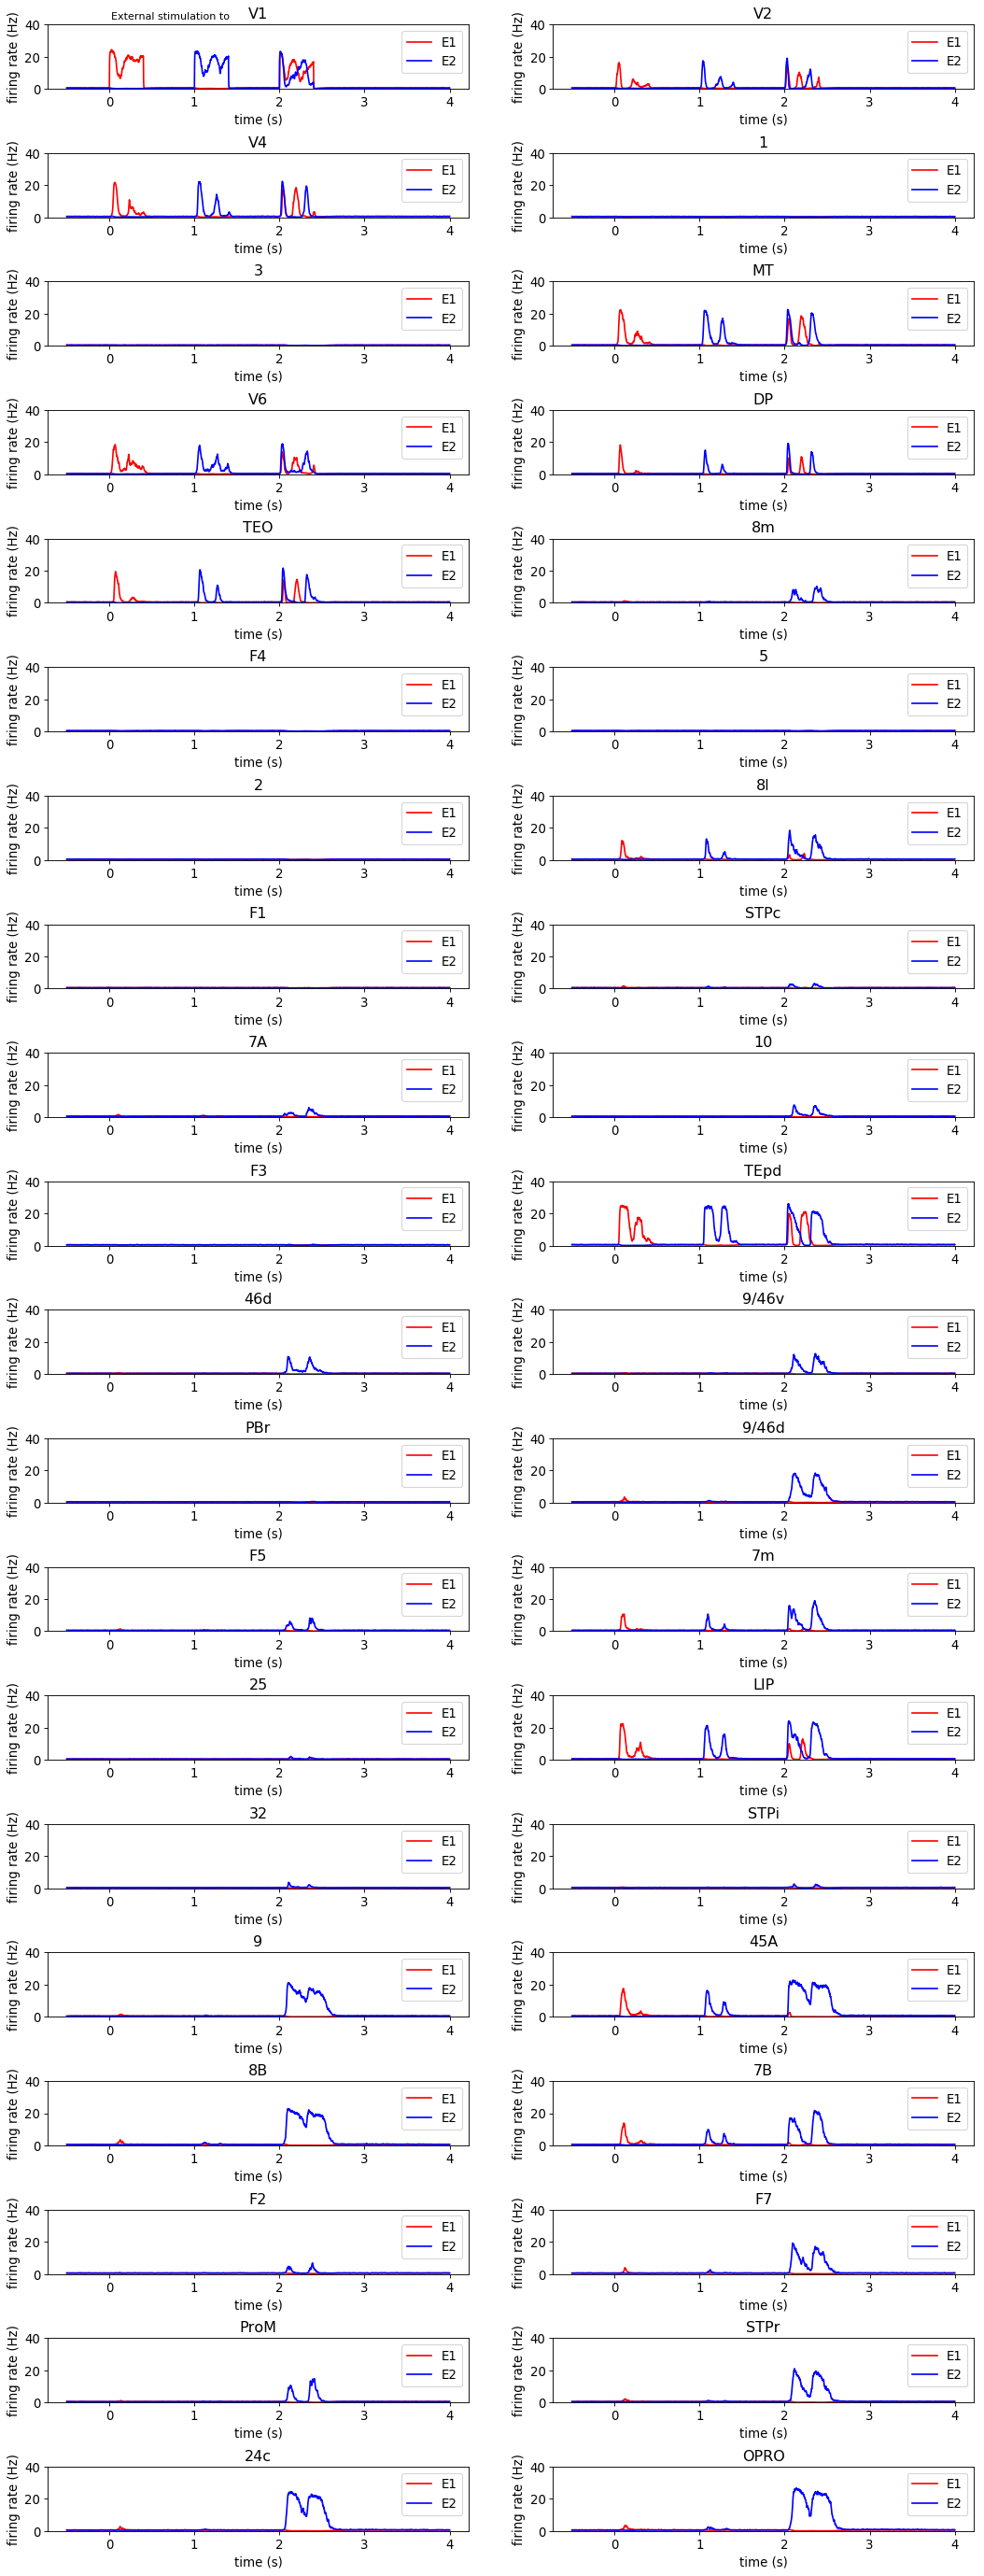

In [35]:
pops_to_plot = ['E1','E2']
start_time = 10.5
end_time = 15
plot_all_areas(start_time,end_time,num_areas,area_list_SLN,R,PARAMS,pops_to_plot)

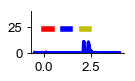

In [36]:
pops_to_plot = ['E1','E2']
area_to_plot = '46d'
start_time = 10.5
end_time = 15
# plot_single_area(start_time,end_time,num_areas,area_list_SLN,R,PARAMS,pops_to_plot,area_to_plot)
plot_single_area(start_time,end_time,num_areas,area_list_SLN,R,PARAMS,pops_to_plot,area_to_plot,'/Users/seanfw/Dropbox/SFW_Wang_projects/Active_projects/Large_scale_monkey_dopamine_WM/Paper_draft/visualisations/figures/DA_0pt5_rates_CueDistPing_' + area_to_plot + '_FEF')



In [38]:
def plot_single_area_syneff(start_time,end_time,num_areas,area_list_SLN,u,x,parameters,pops_to_show,area_to_show,filename):

    hfont = {'fontname':'Arial'}
          
    i = area_list_SLN.index(area_to_show)+1

    fig=plt.figure(figsize=(1.5,0.7), dpi= 80, facecolor='w', edgecolor='k')
#     start_time = 0.5 #seconds
#     end_time = 5 #seconds
    plt.rcParams.update({'font.size': 12})

    # Plot the synaptic efficacy versus baseline - population 1
    plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),(x[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,0]*u[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,0])/(np.mean(x[np.arange(int(start_time/PARAMS['dt']),int((start_time+0.5)/PARAMS['dt']),1),i-1,0]*u[np.arange(int(start_time/PARAMS['dt']),int((start_time+0.5)/PARAMS['dt']),1),i-1,0])),color='r',linewidth=3.0)
    # Plot the synaptic efficacy versus baseline - population 2
    plt.plot(np.arange(start_time*brian2.second-parameters['stim_on'],end_time*brian2.second - parameters['stim_on'] ,PARAMS['dt']),(x[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,1]*u[np.arange(int(start_time/PARAMS['dt']),int(end_time/PARAMS['dt']),1),i-1,1])/(np.mean(x[np.arange(int(start_time/PARAMS['dt']),int((start_time+0.5)/PARAMS['dt']),1),i-1,1]*u[np.arange(int(start_time/PARAMS['dt']),int((start_time+0.5)/PARAMS['dt']),1),i-1,1])),color='b',linewidth=3.0)

    axes = plt.gca()

#     plt.ylabel('synaptic efficacy')
    # plt.ylabel('rates')

    # plt.plot([0*brian2.second,PARAMS['stim_off']-PARAMS['stim_on']],[2,2],color='r',linewidth=10.0)
    # plt.plot([1*brian2.second,PARAMS['dist_off']-PARAMS['dist_on']],[2,2],color='b',linewidth=10.0)
    # Plot the stimulation time   
    plt.plot([(start_time-10.5)*brian2.second,(start_time-10.1)*brian2.second],[2,2],color='r',linewidth=5.0)
    plt.plot([(start_time-9.5)*brian2.second,(start_time-9.1)*brian2.second],[2,2],color='y',linewidth=5.0)

#     axes.text(0.05, 1.2,'target', transform=axes.transAxes, fontsize=15, verticalalignment='top',color='r')
#     axes.text(0.33, 1.2,'probe', transform=axes.transAxes, fontsize=15, verticalalignment='top',color='y')

    # # # Plot the stimulation time


    # if i==1:
    #     axes.text(0.15, 1.2,'External stimulation to', transform=axes.transAxes, fontsize=10, verticalalignment='top')

#     plt.legend(['E1 efficacy', 'E2 efficacy'], prop={'size': 12})

    # Hide the right and top spines
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    axes.yaxis.set_ticks_position('left')
    axes.xaxis.set_ticks_position('bottom')
    
    for tick in axes.get_xticklabels():
        tick.set_fontname("Arial")
    for tick in axes.get_yticklabels():
        tick.set_fontname("Arial")
        
    fig.savefig(filename+'.pdf', dpi=300,bbox_inches='tight',transparent=True)

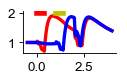

In [39]:
pops_to_plot = ['E1']
area_to_plot = 'V1'
start_time = 10.5
end_time = 15
plot_single_area_syneff(start_time,end_time,num_areas,area_list_SLN,u,x,PARAMS,pops_to_plot,area_to_plot,'/Users/seanfw/Dropbox/SFW_Wang_projects/Active_projects/Large_scale_monkey_dopamine_WM/Paper_draft/visualisations/figures/DA_0pt5_SynEff_CueDistPing_' + area_to_plot + '_FEF')



In [25]:
# Save model outputs

# DA_level = '1pt5'

# # Save the firing rates
# # Remove the run-in time 
# R_trial = copy.deepcopy(R[20000:,:,:])
# np.save('DA_{}_rates_STF_CueDistPing_FEF.npy'.format(DA_level), R_trial)


# data = {}

# data.update({'R': R_trial}) # firing rates 

# sio.savemat('DA_{}_rates_STF_CueDistPing_FEF.mat'.format(DA_level), data)



# # Save the facilitation variable
# u_trial = copy.deepcopy(u[20000:,:,:])

# np.save('DA_{}_u_STF_CueDistPing_FEF.npy'.format(DA_level), u_trial)


# data = {}

# data.update({'u': u_trial}) # firing rates 

# sio.savemat('DA_{}_u_STF_CueDistPing_FEF.mat'.format(DA_level), data)

# # Save the depression variable
# x_trial = copy.deepcopy(x[20000:,:,:])

# np.save('DA_{}_x_STF_CueDistPing_FEF.npy'.format(DA_level), x_trial)


# data = {}

# data.update({'x': x_trial}) # firing rates 

# sio.savemat('DA_{}_x_STF_CueDistPing_FEF.mat'.format(DA_level), data)
